In [1]:
from utils import load_config
import yaml
import os
os.chdir('../../../Interpretable-Deep-Fake-Detection/training/')
import torch
import random
# init seed
# init_seed(config)

torch.manual_seed(34)
random.seed(34)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False  # Disable for strict reproducibility
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()
# torch.cuda.reset_peak_memory_stats()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    torch.cuda.set_device(0)
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import sys
# os.environ["CUDA_VISIBLE_DEVICES"] = "" 
sys.argv = ["train.py"]
from train import init_seed, prepare_training_data, prepare_testing_data, choose_optimizer, choose_scheduler, choose_metric
import torch.backends.cudnn as cudnn
import torch.distributed as dist
from datetime import timedelta
from detectors import DETECTOR
from trainer.trainer import Trainer
# from test import test_epoch, test_one_dataset, test_epoch, inference
from tqdm import tqdm
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
import numpy as np

2025-04-29 13:26:07.042175: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-29 13:26:07.055033: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745925967.069499 2654697 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745925967.074016 2654697 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 13:26:07.090847: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# loading configs

In [2]:
base_path = '/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/weights/best_weights/'
pretrained_paths = [f'{base_path}resnet34.pth',
                    f'{base_path}resnet34_bcos_1_25.pth',
                   f'{base_path}resnet34_bcos_2_5.pth',
                   f'{base_path}vit_bcos_1_25.pth',
                   f'{base_path}vit_bcos_1_75.pth',
                   f'{base_path}vit_bcos_2_5.pth',
                   ]
# ------------------   Resnets
resnet34_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[0],
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/resnet34_best_hpo.yaml"
config_resnet34 = load_config(path, additional_args=resnet34_args)


resnet34_1_25_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[1],
                      'compression': 'c23',
                  # 'backbone_config':{'b': 1.25}
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/resnet34_bcos_v2_1_25_best_hpo.yaml"
config_resnet34_1_25 = load_config(path, additional_args=resnet34_1_25_args)

resnet34_2_5_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[2],
                  # 'backbone_config':{'b': 1.25}
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/resnet34_bcos_v2_2_5_best_hpo.yaml"
config_resnet34_2_5 = load_config(path, additional_args=resnet34_2_5_args)

configs = [config_resnet34, config_resnet34_1_25, config_resnet34_2_5]

# ---------------------  vit
vit_1_25_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[3],
                  # 'backbone_config':{'b': 1.25}
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/vit_bcos_1_25_best_hpo.yaml"
config_vit_1_25 = load_config(path, additional_args=vit_1_25_args)


vit_1_75_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[4],
                  # 'backbone_config':{'b': 1.25}
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/vit_bcos_1_75_best_hpo.yaml"
config_vit_1_75 = load_config(path, additional_args=vit_1_75_args)


vit_2_5_args = {'test_batchSize': 8,
                  'pretrained': pretrained_paths[5],
                  # 'backbone_config':{'b': 1.25}
                  }
path = "/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/BWCluster/test/vit_bcos_2_5_best_hpo.yaml"
config_vit_2_5 = load_config(path, additional_args=vit_2_5_args)

vit_configs = [config_vit_1_25, config_vit_1_75, config_vit_2_5]


test_data_loaders = prepare_testing_data(configs[1])

/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FaceForensics++
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FF-F2F
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FF-DF
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FF-FS
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FF-NT
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
Celeb-DF-v2
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
DFDCP
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
FaceShifter
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset_json_v3
DeepFakeDetection
/pfs/work9/workspace/scratch/ma_tischuet-team_project_explainable_deepfakes/dataset

# Heatmap visualization

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import OrderedDict
from tqdm import tqdm
from bcos.interpretability import grad_to_img, to_numpy
import ipywidgets as widgets

def create_heatmap_visualization(test_data_loaders, configs, threshold=0.1, num_samples=6, random_seed=0):
    """
    Creates a visualization grid with original images and heatmaps from different models.
    
    Args:
        test_data_loaders: Dictionary of test data loaders
        configs: List of model configurations with different 'b' values
        threshold: Threshold value for binarizing heatmaps (default: 0.1)
        num_samples: Number of image samples to display (default: 6)
    
    Returns:
        fig: The matplotlib figure object
    """
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Number of models to display
    num_models = len(configs)
    
    # Create figure with 2 rows per sample (original and thresholded)
    # and columns for original image + each model's heatmap
    fig, axes = plt.subplots(num_samples * 2, num_models + 1, 
                            figsize=(3.5 * (num_models + 1), 3 * num_samples * 2))
    
    # Choose a specific dataset (FaceForensics++ in this case)
    dataset_key = 'FaceForensics++'

    # Add column labels at the top of the figure
    for model_idx, config in enumerate(configs):
        col_idx = model_idx + 1

    for model_idx, config in enumerate(configs):
        sample_count = 0
        col_idx = model_idx + 1
        # Prepare the model (detector)
        model_class = DETECTOR[config['model_name']]
        model = model_class(config)
        state_dict = torch.load(config['pretrained'])
        
        # Remove "module." prefix if present in the state_dict
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_key = k.replace("module.", "")  # Remove "module." prefix
            new_state_dict[new_key] = v
        model.load_state_dict(new_state_dict)
        model.to(device)
        if model_idx == 0:
            # Create a list to store sampled batch indices and sample indices
            sampled_indices = []
        # Loop through data loaders and process the first batch
        for i, data_dict in tqdm(enumerate(test_data_loaders[dataset_key]), total=min(num_samples, len(test_data_loaders[dataset_key]))):
            if i >= num_samples:
                break
            # Process data and ensure labels are binary (0 or 1)
            img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')
            data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

            for key in data_dict.keys():
                if data_dict[key] is not None:
                    data_dict[key] = data_dict[key].to(device)


            # For the first model, randomly select an image from the batch and store the index
            # For subsequent models, use the same indices for consistency
            batch_size = img_batch.size(0)
            
            if model_idx == 0:
                if batch_size > 1:
                    # Randomly sample an image from the batch
                    sample_idx = np.random.randint(0, batch_size)
                else:
                    # Use the first image if not sampling or batch size is 1
                    sample_idx = 0
                # Store this index for consistent use across models
                sampled_indices.append(sample_idx)
            else:
                # Use the same sample index as the first model
                sample_idx = sampled_indices[i]

            # Take the first image and process it
            img = img_batch[sample_idx].unsqueeze(0).to(device)
            label = label_batch[sample_idx].item()  # Get the scalar value

            # Generate explanation
            model.backbone.eval()
            explanation = model.backbone.explain(img)

            # Get explanation map
            explanation_map = explanation['explanation'].copy()
            
            # Create thresholded version
            thresholded_map = explanation_map.copy()
            thresholded_map[:, :, -1] = (thresholded_map[:, :, -1] > threshold).astype(np.uint8)
            img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

            # Row indices for this sample
            original_row = i * 2
            threshold_row = i * 2 + 1
            
            # Display original image in first column of both rows
            for row in [original_row, threshold_row]:
                axes[row, 0].imshow(img_np)
                # Remove titles and add text annotations instead
                # Add label as text annotation instead of title
                axes[row, 0].text(0.5, 0.02, f"True label: {label}", 
                                transform=axes[row, 0].transAxes,
                                color='white', fontsize=10, ha='center', va='bottom',
                                bbox=dict(boxstyle="round,pad=0.3", fc="black", alpha=0.7))
                axes[row, 0].set_xticks([])
                axes[row, 0].set_yticks([])
                
                # Add row label on the left
                if model_idx == 0:
                    row_label = "Original Heatmap" if row == original_row else f"Thresholded to >{threshold}"
                    axes[row, 0].text(-0.15, 0.5, row_label, 
                                    transform=axes[row, 0].transAxes, 
                                    fontsize=12, rotation=90, va='center', ha='center')

            # Plot original heatmap (top row)
            im = axes[original_row, col_idx].imshow(explanation_map, 
                                               cmap='jet', 
                                               alpha=0.5, 
                                               extent=(0, config['resolution'], 0, config['resolution']))
            
            # Add prediction as text annotation instead of title
            pred_value = explanation['prediction']
            pred_color = 'green' if (pred_value > 0.5 and label == 1) or (pred_value <= 0.5 and label == 0) else 'red'
            
            axes[original_row, col_idx].text(0.5, 0.02, f"Pred: {pred_value:.2f}", 
                                         transform=axes[original_row, col_idx].transAxes,
                                         color='white', fontsize=10, ha='center', va='bottom',
                                         bbox=dict(boxstyle="round,pad=0.3", fc=pred_color, alpha=0.7))
            if i==0:
                title = f"b={config['backbone_config']['b']}"
            else:
                title = f""
            axes[original_row, col_idx].set_title(title)
            axes[original_row, col_idx].set_xticks([])
            axes[original_row, col_idx].set_yticks([])
            
            # Plot thresholded heatmap (bottom row)
            im = axes[threshold_row, col_idx].imshow(thresholded_map, 
                                                cmap='jet', 
                                                alpha=0.5, 
                                                extent=(0, config['resolution'], 0, config['resolution']))
            
            axes[threshold_row, col_idx].set_xticks([])
            axes[threshold_row, col_idx].set_yticks([])
    
    # Improve spacing
    plt.subplots_adjust(wspace=0.1, hspace=0.15, top=0.95, bottom=0.05, left=0.07, right=0.95)
    
    return fig

/pfs/data6/home/ma/ma_ma/ma_kreffert/Interpretable-Deep-Fake-Detection/training/bcos/common.py:181: UserWarning: Input tensor did not require grad! Has been set automatically to True!
  warnings.warn(
100%|██████████| 6/6 [00:00<00:00, 19.07it/s]


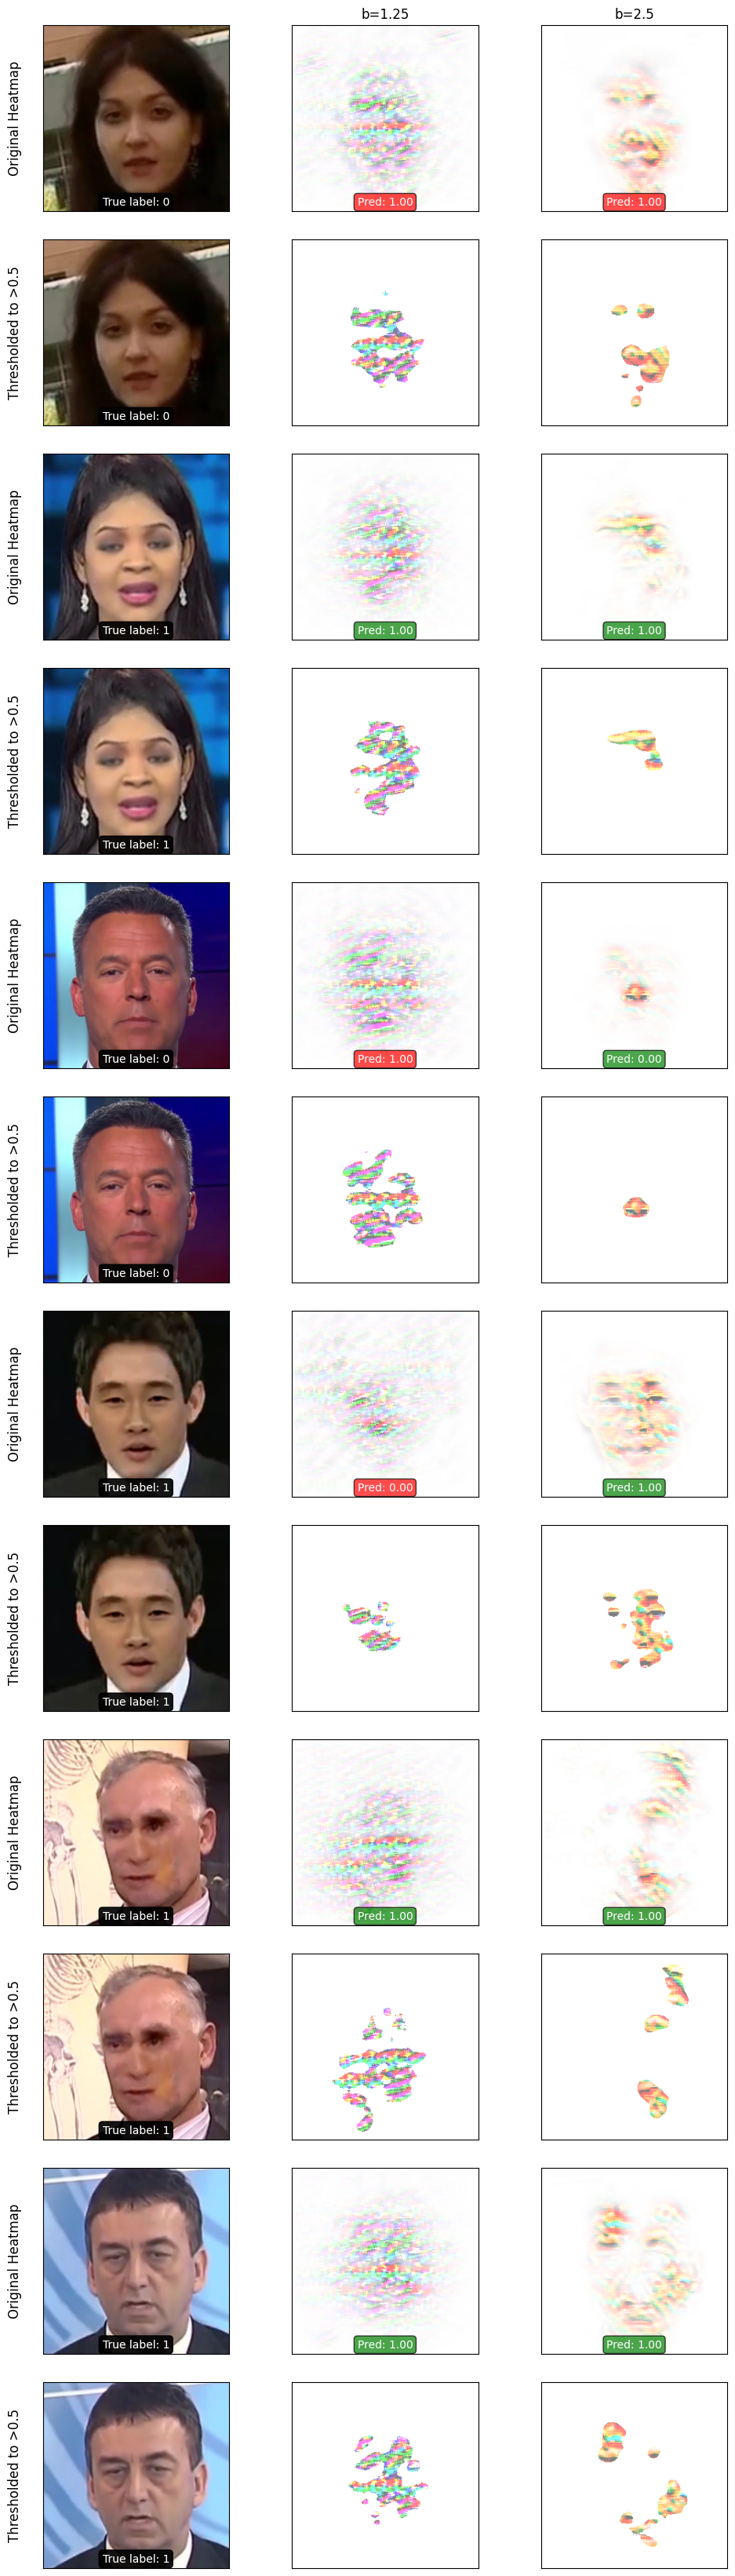

In [4]:
# Example usage:
fig = create_heatmap_visualization(test_data_loaders, configs[1:], threshold=0.5, num_samples=6, random_seed=1)
# plt.savefig('resnet_heatmap_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

100%|██████████| 6/6 [00:00<00:00, 17.11it/s]


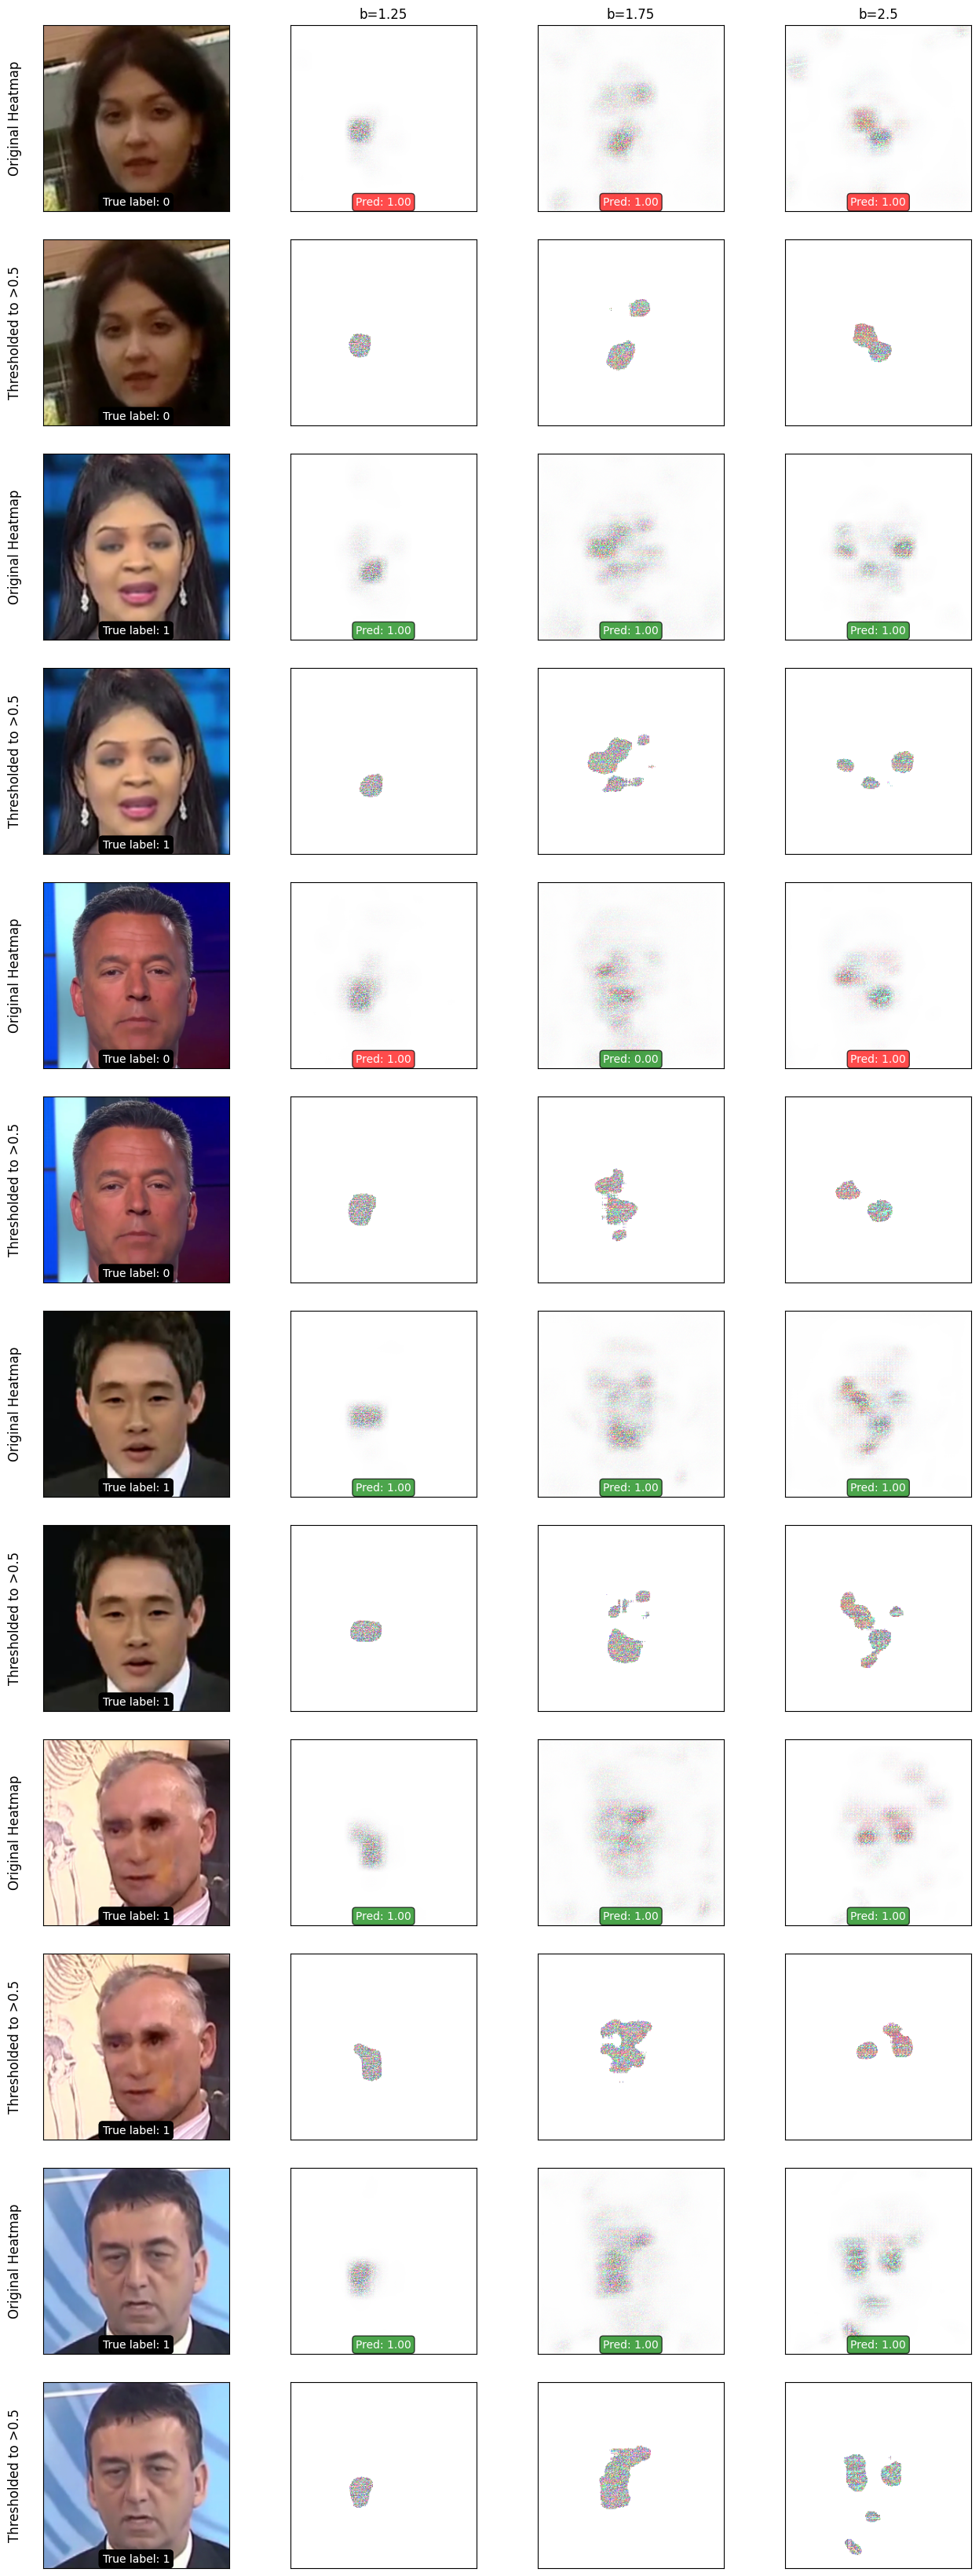

In [5]:
# test_data_loaders = prepare_testing_data(configs[1])

# Example usage:
fig = create_heatmap_visualization(test_data_loaders, vit_configs, threshold=0.5, num_samples=6, random_seed=1)
# plt.savefig('vit_heatmap_visualization.png', dpi=300, bbox_inches='tight')
plt.show()

# Mask Game

100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


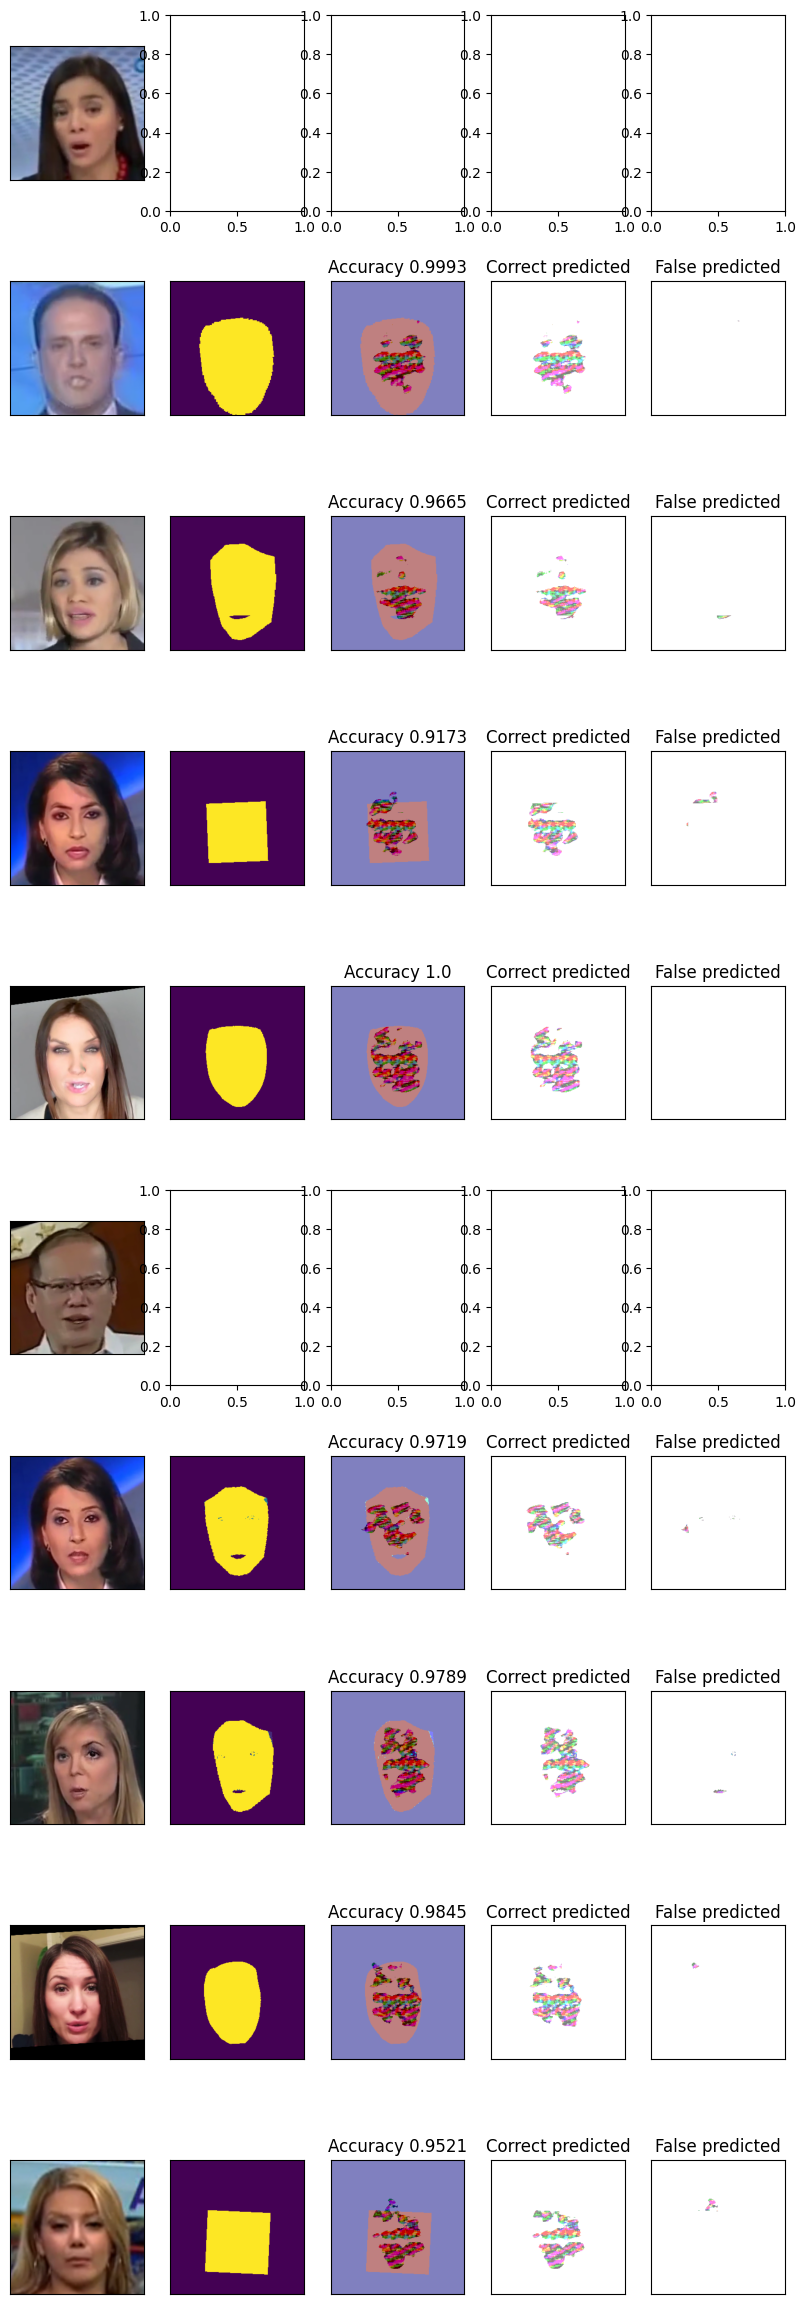

In [8]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from bcos.interpretability import grad_to_img, to_numpy

def mask_game(mask, heatmap):
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().numpy()  # Convert tensor to numpy array
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()  # Convert tensor to numpy array
    heatmap = heatmap[:, :, -1:].copy()
    # Ensure both are in the 0-1 range (binary)
    if np.max(heatmap) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("heatmap range may be wrong")
        heatmap = np.where(heatmap > 0, 1, 0)

    if np.max(mask) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("mask range may be wrong")
        mask = np.where(mask > 0, 1, 0)
        
    # assuming mask is a tensor or numpy array
    correct_pixels = np.sum((heatmap == 1) & (mask == 1))  # Pixels that are both predicted as "1" and ground truth "1"
    # print(np.array((heatmap == 1) & (mask == 1)).shape)
    total_predicted_pixels = np.sum(heatmap == 1)  # Total ground truth pixels that are part of the mask
    # print(np.array(heatmap == 1).shape)
    # Step 5: Compute the performance metric (e.g., accuracy)
    accuracy = correct_pixels / total_predicted_pixels if total_predicted_pixels > 0 else 0  # Accuracy based on mask region
    
    # Optionally, calculate Intersection over Union (IoU) for better performance measurement
    intersection = correct_pixels
    union = np.sum((heatmap == 1) | (mask == 1))  # Union of predicted mask and ground truth mask
    iou = intersection / union if union > 0 else 0  # IoU
    
    # Print performance results
    # print(f"Correct Pixels: {correct_pixels}")
    # print(f"Total Mask Pixels: {total_predicted_pixels}")
    # print(f"Accuracy: {accuracy:.4f}")
    # print(f"Intersection over Union (IoU): {iou:.4f}")
    return accuracy.round(4)

# config = configs[1]
for config in configs[:1]:
    # config['ddp'] = False
    # config['with_mask'] = True
    # test_data_loaders = prepare_testing_data(config)
    num_samples = 10
    threshold = 0.5
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    fig, axes = plt.subplots(num_samples, 5, figsize=(10, num_samples*3))
    dataset_key = 'FaceForensics++'
    
    # load model
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.to(device)
    
    for i, data_dict in tqdm(enumerate(test_data_loaders[dataset_key]), total=min(num_samples, len(test_data_loaders[dataset_key]))):
        if i >= num_samples:
            break
        # Process data and ensure labels are binary (0 or 1)
        img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
        if 'label_spe' in data_dict:
            data_dict.pop('label_spe')
        data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)
    
        for key in data_dict.keys():
            if data_dict[key] is not None:
                data_dict[key] = data_dict[key].to(device)
    
        # Take the first image and process it
        img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
        label = label_batch[0]
        mask = mask[0].to('cpu')
    
        # Generate explanation (replace with your actual explanation function)
        model.backbone.eval()
        explanation = model.backbone.explain(img)
    
        # Apply threshold to the explanation heatmap to binarize it
        explanation_map = explanation['explanation'][:, :, :].copy()
        explanation_map[:, :, -1] = (explanation_map[:, :, -1] > threshold).astype(np.uint8)  # Convert to 0 or 1 based on threshold
    
    
        
        
        img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)
        row_idx = i 
        # Plot the original image on the left subplot
        axes[row_idx, 0].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
        # axes[row_idx, 0].set_title(f"Label {label}")
        #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
        axes[row_idx, 0].set_xticks([])
        axes[row_idx, 0].set_yticks([])
        if mask.max()>0.1:
            # print(mask.shape)
            # print(mask.max())
            mask_np = np.array(mask*255)#to_numpy(mask[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)
    
            # Plot the original image on the left subplot
            axes[row_idx, 1].imshow(mask_np, extent=(0, config['resolution'], 0, config['resolution']))
            # axes[row_idx, 1].set_title(f"Label {label}")
            #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
            axes[row_idx, 1].set_xticks([])
            axes[row_idx, 1].set_yticks([])
    
            axes[row_idx, 2].imshow(explanation_map, extent=(0, config['resolution'], 0, config['resolution']))
            axes[row_idx, 2].imshow(mask_np, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
            accuracy = mask_game(mask, explanation_map)
            axes[row_idx, 2].set_title(f"Accuracy {accuracy}")
            #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
            axes[row_idx, 2].set_xticks([])
            axes[row_idx, 2].set_yticks([])
    
            mask = mask.cpu().numpy()
            correct = np.array((explanation_map == 1) & (mask == 1))
            # correct = np.array((explanation_map == 1))
            correct = correct*255
            axes[row_idx, 3].imshow(correct, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
            axes[row_idx, 3].set_title("Correct predicted")
            #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
            axes[row_idx, 3].set_xticks([])
            axes[row_idx, 3].set_yticks([])
            
            wrong = np.array((explanation_map == 1) & (mask != 1))
            # correct = np.array((explanation_map == 1))
            wrong = wrong*255
            axes[row_idx, 4].imshow(wrong, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))  # Add alpha for transparency
            axes[row_idx, 4].set_title("False predicted")
            #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
            axes[row_idx, 4].set_xticks([])
            axes[row_idx, 4].set_yticks([])

Evaluating model: resnet34_bcos_v2_0


100%|██████████| 5/5 [00:00<00:00, 15.04it/s]


Model resnet34_bcos_v2_0: Average accuracy = 0.9226 over 5 samples


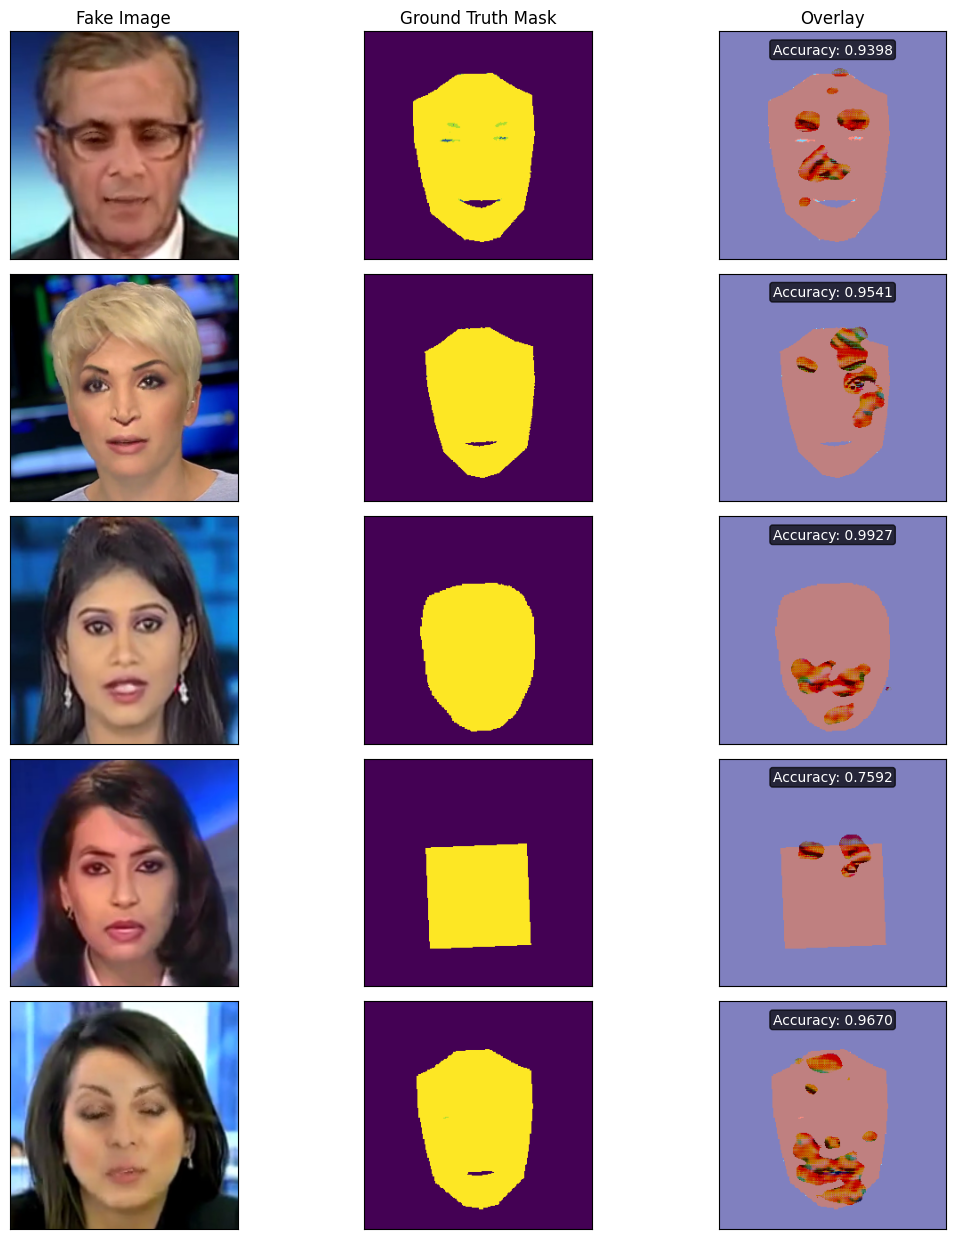

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from collections import OrderedDict
from tqdm import tqdm
from bcos.interpretability import to_numpy

def mask_game(mask, heatmap):
    """
    Calculate accuracy metrics between a predicted heatmap and ground truth mask.
    
    Args:
        mask: Ground truth mask (numpy array or torch tensor)
        heatmap: Predicted heatmap (numpy array or torch tensor)
        
    Returns:
        float: Accuracy score rounded to 4 decimal places
    """
    if isinstance(heatmap, torch.Tensor):
        heatmap = heatmap.cpu().numpy()  # Convert tensor to numpy array
    if isinstance(mask, torch.Tensor):
        mask = mask.cpu().numpy()  # Convert tensor to numpy array
    
    # Extract the last channel if it exists
    if len(heatmap.shape) > 2 and heatmap.shape[2] > 0:
        heatmap = heatmap[:, :, -1:].copy()
    
    # Ensure both are in the 0-1 range (binary)
    if np.max(heatmap) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("heatmap range may be wrong")
        heatmap = np.where(heatmap > 0, 1, 0)

    if np.max(mask) > 1:  # If values are in 0-255 (image format), threshold to 0 or 1
        print("mask range may be wrong")
        mask = np.where(mask > 0, 1, 0)
        
    # Calculate metrics
    correct_pixels = np.sum((heatmap == 1) & (mask == 1))  # True positives
    total_predicted_pixels = np.sum(heatmap == 1)  # Total predicted positive pixels
    
    # Compute accuracy
    accuracy = correct_pixels / total_predicted_pixels if total_predicted_pixels > 0 else 0
    
    # Calculate IoU (Intersection over Union)
    intersection = correct_pixels
    union = np.sum((heatmap == 1) | (mask == 1))  # Union of predicted mask and ground truth mask
    iou = intersection / union if union > 0 else 0
    
    return accuracy.round(4)

def evaluate_masks(test_data_loaders, configs, DETECTOR, threshold=0.5, num_samples=10, random_seed=42, 
                   dataset_key='FaceForensics++', evaluate_all=False, plot_results=True):
    """
    Evaluates mask predictions against ground truth masks for one or multiple models.
    
    Args:
        test_data_loaders: Dictionary of test data loaders
        configs: List of model configurations
        DETECTOR: Dictionary mapping model names to model classes
        threshold: Threshold for binarizing the explanation heatmap (default: 0.5)
        num_samples: Number of samples to evaluate when not evaluating all (default: 10)
        random_seed: Random seed for reproducibility (default: 42)
        dataset_key: Key for selecting the dataset from test_data_loaders (default: 'FaceForensics++')
        evaluate_all: If True, evaluate all samples in test set; if False, evaluate num_samples (default: False)
        plot_results: If True, create and return visualization plot (default: True)
        
    Returns:
        tuple: (matplotlib figure if plot_results=True, dict of accuracy results per model)
    """
    # Set random seeds for reproducibility
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    # Determine device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Store results for each model
    results = {}
    
    # Create figure for visualization if requested
    fig = None
    if plot_results and not evaluate_all:
        # Create a more compact figure with tight spacing
        fig, axes = plt.subplots(num_samples, 3, figsize=(12, num_samples*2.5))
        plt.subplots_adjust(wspace=0.05, hspace=0.1)  # Reduce spacing between subplots
        
        # Handle single sample case
        if num_samples == 1:
            axes = axes.reshape(1, -1)
    
    # For each model configuration
    for config_idx, config in enumerate(configs):
        if config_idx == 0:
            sampled_indices = []
        model_name = config['model_name']
        model_key = f"{model_name}_{config_idx}"
        
        print(f"Evaluating model: {model_key}")
        
        # Initialize model
        model_class = DETECTOR[model_name]
        model = model_class(config)
        
        # Load pre-trained weights
        state_dict = torch.load(config['pretrained'])
        new_state_dict = OrderedDict()
        for k, v in state_dict.items():
            new_key = k.replace("module.", "")  # Remove "module." prefix
            new_state_dict[new_key] = v
        model.load_state_dict(new_state_dict)
        model.to(device)
        model.eval()
        
        # Initialize accuracy list for this model
        accuracies = []
        
        # Determine total samples to process
        total_samples = len(test_data_loaders[dataset_key]) if evaluate_all else min(num_samples, len(test_data_loaders[dataset_key]))
        
        # Process samples
        sample_count = 0
        for i, data_dict in tqdm(enumerate(test_data_loaders[dataset_key]), total=total_samples):
            if not evaluate_all and i >= num_samples:
                break
                
            # Process data and ensure labels are binary (0 or 1)
            img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
            if 'label_spe' in data_dict:
                data_dict.pop('label_spe')
            data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)
        
            # Move data to device
            for key in data_dict.keys():
                if data_dict[key] is not None:
                    data_dict[key] = data_dict[key].to(device)
            
            # Process each image in the batch
            batch_size = img_batch.size(0)
            
            if config_idx == 0:
                if batch_size > 1:
                    # Randomly sample an image from the batch
                    sample_idx = np.random.randint(0, batch_size)
                else:
                    # Use the first image if not sampling or batch size is 1
                    sample_idx = 0
                # Store this index for consistent use across models
                sampled_indices.append(sample_idx)
            else:
                # Use the same sample index as the first model
                sample_idx = sampled_indices[i]

            # Take the first image and process it
            img = img_batch[sample_idx].unsqueeze(0).to(device)
            label = label_batch[sample_idx].item()  # Get the scalar value
            
            # for batch_idx in range(batch_size):
            #     # Take a single image and process it
            #     img = img_batch[batch_idx].unsqueeze(0).to(device)
            #     label = label_batch[batch_idx]
            sample_mask = mask[sample_idx].to('cpu')
            
            # If mask doesn't exist or is empty, skip this sample
            if sample_mask.max() <= 0.1:
                continue
            
            # Generate explanation
            with torch.no_grad():
                model.backbone.eval()
                explanation = model.backbone.explain(img)
            
            # Apply threshold to the explanation heatmap to binarize it
            explanation_map = explanation['explanation'][:, :, :].copy()
            explanation_map[:, :, -1] = (explanation_map[:, :, -1] > threshold).astype(np.uint8)
            
            # Calculate accuracy for this sample
            sample_accuracy = mask_game(sample_mask, explanation_map)
            accuracies.append(sample_accuracy)
            
            # If plotting and this is one of the samples to plot
            if plot_results and not evaluate_all and sample_count < num_samples:
                # Convert image tensor to numpy for visualization
                img_np = to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255
                img_np = np.array(img_np, dtype=np.uint8)
                
                # Plot original image
                axes[sample_count, 0].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                # Only add title to first row
                if sample_count == 0:
                    axes[sample_count, 0].set_title("Fake Image")
                axes[sample_count, 0].set_xticks([])
                axes[sample_count, 0].set_yticks([])
                
                # Plot ground truth mask
                mask_np = np.array(sample_mask * 255)
                axes[sample_count, 1].imshow(mask_np, extent=(0, config['resolution'], 0, config['resolution']))
                # Only add title to first row
                if sample_count == 0:
                    axes[sample_count, 1].set_title("Ground Truth Mask")
                axes[sample_count, 1].set_xticks([])
                axes[sample_count, 1].set_yticks([])
                
                # Plot overlay of prediction and ground truth
                axes[sample_count, 2].imshow(explanation_map, extent=(0, config['resolution'], 0, config['resolution']))
                axes[sample_count, 2].imshow(mask_np, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                # Only add title to first row
                if sample_count == 0:
                    axes[sample_count, 2].set_title("Overlay")
                axes[sample_count, 2].set_xticks([])
                axes[sample_count, 2].set_yticks([])
                
                # Add accuracy text on top of each image
                for col in range(3):
                    text_color = 'white' if col != 1 else 'black'  # Use black text for the mask image
                    if col == 2:  # Add accuracy only to overlay image
                        accuracy_text = f"Accuracy: {sample_accuracy:.4f}"
                    else:
                        accuracy_text = ""
                        
                    if accuracy_text:  # Only add text if there's content
                        axes[sample_count, col].text(0.5, 0.95, accuracy_text,
                                                   transform=axes[sample_count, col].transAxes,
                                                   color=text_color, fontsize=10, ha='center', va='top',
                                                   bbox=dict(boxstyle="round,pad=0.2", fc="black", alpha=0.7))
                
                sample_count += 1
    
        # Calculate average accuracy for this model
        avg_accuracy = sum(accuracies) / len(accuracies) if accuracies else 0
        
        # Store results
        results[model_key] = {
            'accuracies': accuracies,
            'avg_accuracy': avg_accuracy,
            'num_samples': len(accuracies)
        }
        
        print(f"Model {model_key}: Average accuracy = {avg_accuracy:.4f} over {len(accuracies)} samples")
    
    # Finalize plot
    if plot_results and not evaluate_all and fig is not None:
        # Add overall title with model and average accuracy
        # fig.suptitle(f"Model: {model_key} - Avg Accuracy: {avg_accuracy:.4f}", fontsize=14)
        plt.tight_layout()  # Adjust layout to make room for suptitle
    
    return (fig, results) if plot_results and not evaluate_all else results

# Example usage:
# -----------------
# 1. Plot visualization for a few samples:

fig, results = evaluate_masks(test_data_loaders, configs[2:3], DETECTOR, num_samples=5, random_seed=0)
plt.savefig('mpg.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def evaluate_multiple_thresholds(test_data_loaders, configs, DETECTOR, thresholds=[0.1, 0.3, 0.5, 0.7, 0.9], 
                                random_seed=42, dataset_key='FaceForensics++', num_eval_samples=100):
    """
    Evaluates mask predictions at multiple threshold values.
    
    Args:
        test_data_loaders: Dictionary of test data loaders
        configs: List of model configurations
        DETECTOR: Dictionary mapping model names to model classes
        thresholds: List of threshold values to evaluate
        random_seed: Random seed for reproducibility
        dataset_key: Key for selecting the dataset from test_data_loaders
        num_eval_samples: Number of samples to evaluate
        
    Returns:
        dict: Results for each model at each threshold
    """
    results = {}
    
    for threshold in thresholds:
        print(f"\nEvaluating with threshold = {threshold}")
        threshold_results = evaluate_masks(
            test_data_loaders=test_data_loaders,
            configs=configs,
            DETECTOR=DETECTOR,
            threshold=threshold,
            num_samples=num_eval_samples,
            random_seed=random_seed,
            dataset_key=dataset_key,
            evaluate_all=True,
            plot_results=False
        )
        
        # Store results for this threshold
        results[threshold] = threshold_results
    
    # Create a summary table
    summary = {}
    for model_key in results[thresholds[0]].keys():
        summary[model_key] = {t: results[t][model_key]['avg_accuracy'] for t in thresholds}
    
    return results, summary

def plot_threshold_comparison(summary, thresholds=[0.1, 0.3, 0.5, 0.7, 0.9]):
    """
    Plot comparison of model accuracies across different thresholds.
    
    Args:
        summary: Summary dictionary from evaluate_multiple_thresholds
        thresholds: List of threshold values evaluated
        
    Returns:
        matplotlib.figure.Figure: The generated plot
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Plot a line for each model
    for model_key, threshold_results in summary.items():
        accuracies = [threshold_results[t] for t in thresholds]
        ax.plot(thresholds, accuracies, marker='o', linewidth=2, label=model_key)
    
    # Add labels and legend
    ax.set_xlabel('Threshold Value')
    ax.set_ylabel('Average Accuracy')
    ax.set_title('Model Performance vs. Threshold Value')
    ax.legend()
    ax.grid(True)
    
    # Set y-axis to start from 0
    ax.set_ylim(bottom=0)
    
    return fig

# 2. Evaluate accuracy on all samples:
# results = evaluate_masks(test_data_loaders, configs[1:], DETECTOR, evaluate_all=True, plot_results=False)
# for model_key, model_results in results.items():
#     print(f"{model_key}: Avg accuracy = {model_results['avg_accuracy']:.4f}")
# #
# # 3. Evaluate multiple thresholds:
# results, summary = evaluate_multiple_thresholds(test_data_loaders, configs[1:], DETECTOR)
# threshold_fig = plot_threshold_comparison(summary)
plt.show()

# Old Code

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn import metrics
from test import inference

models = []
num_batches = 100000
for config in configs[1:]:
    test_data_loaders = prepare_testing_data(config)
    # prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    # Remove "module." prefix
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.cuda()#.to("cuda:0")
    model.eval()
    y_pred = []
    y_true = []
    y_prob = []
    # print(test_data_loaders.keys())
    for key in ['FaceForensics++']:#test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]),total=len(test_data_loaders[key])):
            if i< num_batches:
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')  # remove the specific label
                data_dict['label'] = torch.where(data_dict['label']!=0, 1, 0)  # fix the label to 0 and 1 only
                # move data to GPU elegantly
                for key in data_dict.keys():
                    if data_dict[key]!=None:
                        data_dict[key]=data_dict[key].cuda()
                # model forward without considering gradient computation
                # print(data_dict)
                with torch.no_grad():
                    predictions = inference(model, data_dict)
                y_prob.append(predictions['prob'].cpu().numpy())
                pred = torch.where(predictions['prob']>=0.5, 1, 0)
                y_pred.append(pred.cpu().numpy())
                y_true.append(data_dict['label'].cpu().numpy())
                # print(data_dict['label'])
                # print(predictions['prob'])
            else:
                break
        
        y_pred_flat = np.concatenate(y_pred)
        y_true_flat = np.concatenate(y_true)
        y_prob_flat = np.concatenate(y_prob)
        # Compute confusion matrix
        cm = confusion_matrix(y_true_flat, y_pred_flat)
        print(f"Confusion Matrix for model {config['model_name']}:\n", cm)
        
        # Compute Accuracy
        accuracy = accuracy_score(y_true_flat, y_pred_flat)
        print(f"Accuracy for model {config['model_name']}: {accuracy:.4f}")
    
        # Compute Precision
        precision = precision_score(y_true_flat, y_pred_flat)
        print(f"Precision for model {config['model_name']}: {precision:.4f}")
    
        # Compute Recall
        recall = recall_score(y_true_flat, y_pred_flat)
        print(f"Recall for model {config['model_name']}: {recall:.4f}")
    
        # Compute F1 Score
        f1 = f1_score(y_true_flat, y_pred_flat)
        print(f"F1 Score for model {config['model_name']}: {f1:.4f}")
    
        # Compute ROC AUC (only for binary classification)
        fpr, tpr, thresholds = metrics.roc_curve(y_true_flat,
                                                y_prob_flat,
                                                 pos_label=1)
        auc = metrics.auc(fpr, tpr)
        fnr = 1 - tpr
        eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        print(f"AUC {auc}")
        print(f"EER {eer}")

        # Compute ROC AUC (only for binary classification)
        # fpr, tpr, thresholds = metrics.roc_curve(y_true_flat,
        #                                         y_pred_flat,
        #                                          pos_label=1)
        # auc = metrics.auc(fpr, tpr)
        # fnr = 1 - tpr
        # eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
        # print(f"AUC {auc}")
        # print(f"EER {eer}")
        try:
            roc_auc = roc_auc_score(y_true_flat, y_prob_flat)
            print(f"ROC AUC for model {config['model_name']}: {roc_auc:.4f}")
        except ValueError:
            print(f"ROC AUC is not computable for model {config['model_name']} (likely due to imbalanced classes)")
    models.append(model)

  0%|          | 7/2793 [00:02<16:36,  2.80it/s]


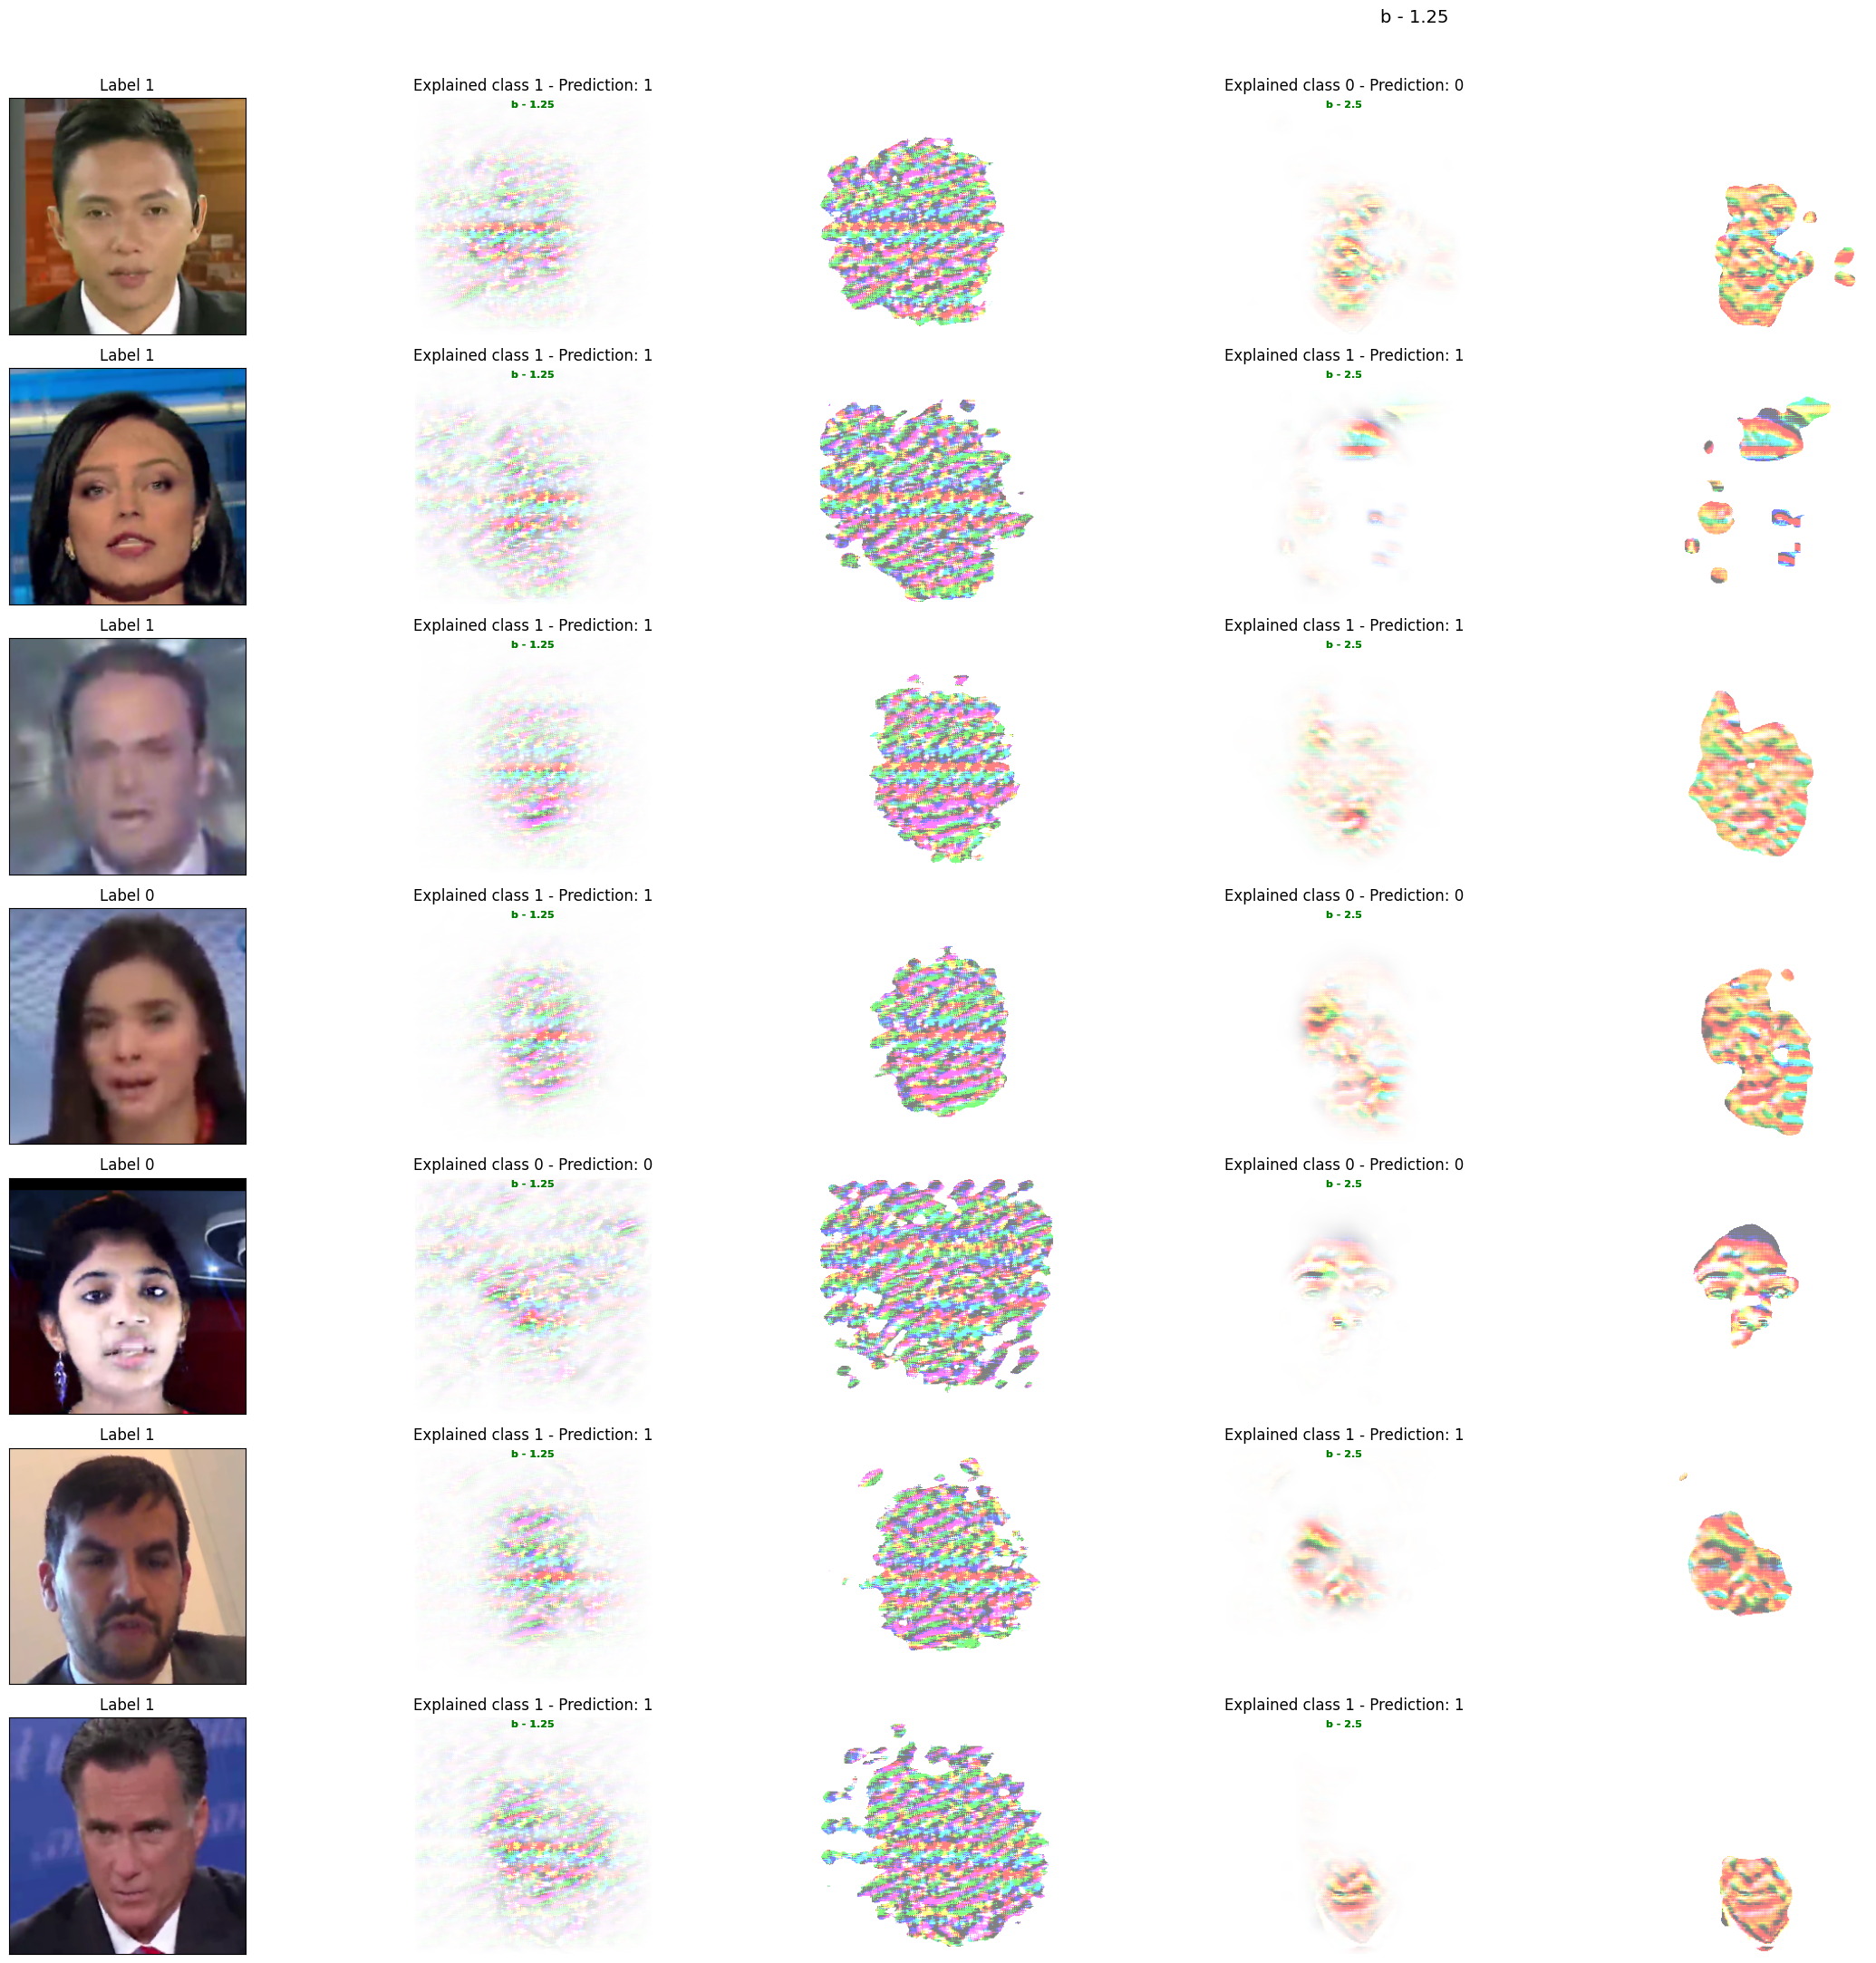

In [14]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from bcos.interpretability import grad_to_img, to_numpy
# Assuming you've already set up device, data loaders, and models
device = torch.device("cpu")

threshold = 0.1
num_plots = 7
fig, axes = plt.subplots(num_plots, 5, figsize=(num_plots* 3, num_plots*3))  
for n in range(len(configs[:-1])):
    if 'b' in configs[n]['backbone_config'].keys():
        fig.text(0.25 + (n/len(configs[:-1])), 1.02, f"b - {configs[n]['backbone_config']['b']}", ha='center', va='bottom', fontsize=14)
# test_data_loaders = prepare_testing_data(configs[0])
for model_idx, config in enumerate(configs[1:]):
    # Prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    
    # Remove "module." prefix if present in the state_dict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.to(device)

    # Loop through data loaders and process the first batch
    for key in ['FaceForensics++']:#test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):
            if i < num_plots:
                # Process data and ensure labels are binary (0 or 1)
                img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')
                data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

                for key in data_dict.keys():
                    if data_dict[key] is not None:
                        data_dict[key] = data_dict[key].to(device)

                # Take the first image and process it
                img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
                label = label_batch[0]

                # Generate explanation (replace with your actual explanation function)
                model.backbone.eval()
                explanation = model.backbone.explain(img)

                # Apply threshold to the explanation heatmap to binarize it
                explanation_map = explanation['explanation'][:, :, :].copy()
                explanation_map[:, :, -1] = (explanation_map[:, :, -1] > threshold).astype(np.uint8)  # Convert to 0 or 1 based on threshold
                
                # Convert the image to numpy format for visualization
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

                # Select subplot axes based on the model index (for arranging in 2x2 grid)
                row_idx = i #model_idx // 2  # Determine row (0 or 1)
                col_idx = model_idx*2+1 #* 2 
                if model_idx == 0:
                    # Plot the original image on the left subplot
                    axes[row_idx, model_idx].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                    axes[row_idx, model_idx].set_title(f"Label {label}")
                    #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                    axes[row_idx, model_idx].set_xticks([])
                    axes[row_idx, model_idx].set_yticks([])

                # Plot the explanation (heatmap) on the right subplot
                axes[row_idx, col_idx].imshow(explanation['explanation'], cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx].set_title(f"Explained class {explanation['explained_class_idx']} - Prediction: {explanation['prediction']}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx].set_xticks([])
                axes[row_idx, col_idx].set_yticks([])
                axes[row_idx, col_idx].text(0.5, .99,  f"b - {config['backbone_config']['b']}", color='green', ha='center', va='top', fontsize=8, weight='bold', transform=axes[row_idx, col_idx].transAxes)
                
                # Plot the explanation (heatmap) on the right subplot
                axes[row_idx, col_idx+1].imshow(explanation_map, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                # axes[row_idx, col_idx+1].set_title(f"Explained class {explanation['explained_class_idx']} - Prediction: {explanation['prediction']}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx+1].set_xticks([])
                axes[row_idx, col_idx+1].set_yticks([])
                axes[row_idx, col_idx+1].text(0.5, .99,  f"b - {config['backbone_config']['b']}", color='green', ha='center', va='top', fontsize=8, weight='bold', transform=axes[row_idx, col_idx].transAxes)

                bbox = axes[row_idx, col_idx].get_position()  # This is a Bbox object
                x_position = (bbox.xmin + bbox.xmax) / 2  # Calculate the center position of the first explanation plot
                y_position = bbox.ymax #(bbox.ymin + bbox.ymax) / 2  # Calculate the center position of the first explanation plot
                
                
                # fig.text(x_position, y_position, "Explanation Maps", ha='center', va='top', fontsize=12, weight='bold')
                
                # Hide axes spines
                for ax in [axes[row_idx, col_idx], axes[row_idx, col_idx + 1]]:
                    for spine in ax.spines.values():
                        spine.set_visible(False)

            else:
                break  # Only process the first 3 batches (or less if break condition met)
        else:
            break  # Exit if the test data loader finishes

plt.subplots_adjust(wspace=0.1)  # Adjust horizontal spacing between columns
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

In [ ]:
explanation_map = explanation['explanation'][:, :, :].copy()
explanation_map[:, :, -1] = (explanation_map[:, :, -1] >0.1).astype(np.uint8)  # Convert to 0 or 1 based on threshold
                
plt.imshow(explanation_map, cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
plt.show()
# plt.imshow(explanation['explanation'][:, :, :], cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
# plt.show()

In [ ]:
import matplotlib.pyplot as plt
from bcos.interpretability import grad_to_img, to_numpy
# Assuming you've already set up device, data loaders, and models
device = torch.device("cpu")

num_plots = 6
fig, axes = plt.subplots(num_plots, 4, figsize=(num_plots* 3, num_plots*3))  
for n in range(len(configs)):
    if 'b' in configs[n]['backbone_config'].keys():
        fig.text(0.25 + (n/len(configs)), 1.02, f"b - {configs[n]['backbone_config']['b']}", ha='center', va='bottom', fontsize=14)
test_data_loaders = prepare_testing_data(configs[0])
for model_idx, config in enumerate(configs[:-1]):
    # Prepare the model (detector)
    model_class = DETECTOR[config['model_name']]
    model = model_class(config)
    state_dict = torch.load(config['pretrained'])
    
    # Remove "module." prefix if present in the state_dict
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        new_key = k.replace("module.", "")  # Remove "module." prefix
        new_state_dict[new_key] = v
    model.load_state_dict(new_state_dict)
    model.to(device)

    # Loop through data loaders and process the first batch
    for key in test_data_loaders.keys():
        for i, data_dict in tqdm(enumerate(test_data_loaders[key]), total=len(test_data_loaders[key])):
            if i < num_plots:
                # Process data and ensure labels are binary (0 or 1)
                img_batch, label_batch, landmark, mask = (data_dict[k] for k in ['image', 'label', 'landmark', 'mask'])
                if 'label_spe' in data_dict:
                    data_dict.pop('label_spe')
                data_dict['label'] = torch.where(data_dict['label'] != 0, 1, 0)

                for key in data_dict.keys():
                    if data_dict[key] is not None:
                        data_dict[key] = data_dict[key].to(device)

                # Take the first image and process it
                img = img_batch[0].unsqueeze(0).to(device)  # Process a single image
                label = label_batch[0]

                # Generate explanation (replace with your actual explanation function)
                model.backbone.eval()
                explanation = model.backbone.explain(img)
                
                # Convert the image to numpy format for visualization
                img_np = np.array(to_numpy(img[0, [0, 1, 2]].permute(1, 2, 0)) * 255, dtype=np.uint8)

                # Select subplot axes based on the model index (for arranging in 2x2 grid)
                row_idx = i #model_idx // 2  # Determine row (0 or 1)
                col_idx = model_idx * 2 

                # Plot the original image on the left subplot
                axes[row_idx, col_idx].imshow(img_np, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx].set_title(f"Label {label}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx].set_xticks([])
                axes[row_idx, col_idx].set_yticks([])

                # Plot the explanation (heatmap) on the right subplot
                axes[row_idx, col_idx+1].imshow(explanation['explanation'], cmap='jet', alpha=0.5, extent=(0, config['resolution'], 0, config['resolution']))
                axes[row_idx, col_idx+1].set_title(f"Explained class {explanation['explained_class_idx']} - Prediction: {explanation['prediction']}")
                #axes[row_idx, col_idx].set_xlim(0, config['resolution'])
                axes[row_idx, col_idx+1].set_xticks([])
                axes[row_idx, col_idx+1].set_yticks([])
                axes[row_idx, col_idx+1].text(0.5, .99,  f"b - {config['backbone_config']['b']}", color='green', ha='center', va='top', fontsize=8, weight='bold', transform=axes[row_idx, col_idx+1].transAxes)

                for spine in axes[row_idx, col_idx].spines.values():
                    spine.set_visible(False)

            else:
                break  # Only process the first 3 batches (or less if break condition met)
        else:
            break  # Exit if the test data loader finishes
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()